In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np


class Conv3x3:
    def __init__(self, num_filters, input_channels):
        # Ensure the filter has the right size: (num_filters, 3, 3, input_channels)
        self.num_filters = num_filters
        self.filters = np.random.randn(num_filters, 3, 3, input_channels) / 9  # Random initialization

    def iterate_regions(self, image):
        h, w, _ = image.shape
        for i in range(h - 2):
            for j in range(w - 2):
                im_region = image[i:(i + 3), j:(j + 3), :]
                yield im_region, i, j

    def forward(self, input):
        self.last_input = input
        h, w, _ = input.shape
        output = np.zeros((h - 2, w - 2, self.num_filters))

        for im_region, i, j in self.iterate_regions(input):
            for f in range(self.num_filters):
                output[i, j, f] = np.sum(im_region * self.filters[f])

        return output

    def backprop(self, d_L_d_out, learn_rate):
        d_L_d_filters = np.zeros(self.filters.shape)
        d_L_d_input = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region
                d_L_d_input[i:i + 3, j:j + 3, :] += d_L_d_out[i, j, f] * self.filters[f]

        self.filters -= learn_rate * d_L_d_filters
        return d_L_d_input



class MaxPool2:
    def iterate_regions(self, image):
        h, w, _ = image.shape
        new_h = h // 2
        new_w = w // 2
        for i in range(new_h):
            for j in range(new_w):
                im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
                yield im_region, i, j

    def forward(self, input):
        self.last_input = input
        h, w, num_filters = input.shape
        output = np.zeros((h // 2, w // 2, num_filters))

        # Max pooling operation
        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.amax(im_region, axis=(0, 1))

        return output

    def backprop(self, d_L_d_out):
        d_L_d_input = np.zeros(self.last_input.shape)

        # Backpropagate the gradients through the pooling layer
        for im_region, i, j in self.iterate_regions(self.last_input):
            h, w, f = im_region.shape
            amax = np.amax(im_region, axis=(0, 1))

            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        if im_region[i2, j2, f2] == amax[f2]:
                            d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

        return d_L_d_input


class Dropout:
    def __init__(self, drop_prob):
        self.drop_prob = drop_prob

    def forward(self, input):
        self.mask = np.random.rand(*input.shape) > self.drop_prob
        return input * self.mask

    def backprop(self, d_L_d_out):
        return d_L_d_out * self.mask


class Softmax:
    def __init__(self, input_len, nodes):
        self.weights = np.random.randn(input_len, nodes) / input_len
        self.biases = np.zeros(nodes)

    def forward(self, input):
        self.last_input_shape = input.shape
        input = input.flatten()
        self.last_input = input

        # Calculate softmax output
        totals = np.dot(input, self.weights) + self.biases
        self.last_totals = totals
        exp = np.exp(totals - np.max(totals))  # For numerical stability
        return exp / np.sum(exp, axis=0)

    def backprop(self, d_L_d_out, learn_rate):
        # Compute gradient for softmax
        grad = np.zeros_like(self.last_totals)
        for i, gradient in enumerate(d_L_d_out):
            if gradient == 0:
                continue

            t_exp = np.exp(self.last_totals)
            S = np.sum(t_exp)

            d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
            d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

            # Backpropagate the gradients through the softmax layer
            d_L_d_t = gradient * d_out_d_t
            self.weights -= learn_rate * np.outer(self.last_input, d_L_d_t)
            self.biases -= learn_rate * d_L_d_t

        return np.dot(self.weights, d_L_d_t).reshape(self.last_input_shape)



170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Dataset 1 (Bird and Cat):
  Train images shape: (320, 32, 32, 3), Train labels shape: (320, 1)
  Validation images shape: (80, 32, 32, 3), Validation labels shape: (80, 1)
  Test images shape: (100, 32, 32, 3), Test labels shape: (100, 1)
Dataset 2 (Deer and Dog):
  Train images shape: (320, 32, 32, 3), Train labels shape: (320, 1)
  Validation images shape: (80, 32, 32, 3), Validation labels shape: (80, 1)
  Test images shape: (100, 32, 32, 3), Test labels shape: (100, 1)
Sample images from Dataset 1 (Airplane and Automobile):


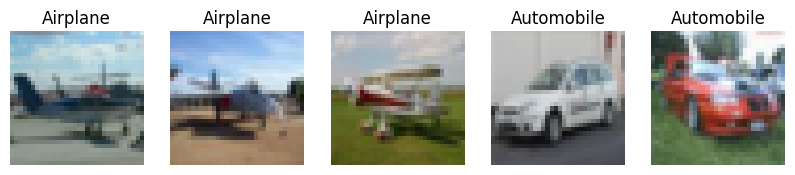

Sample images from Dataset 2 (Bird and Cat):


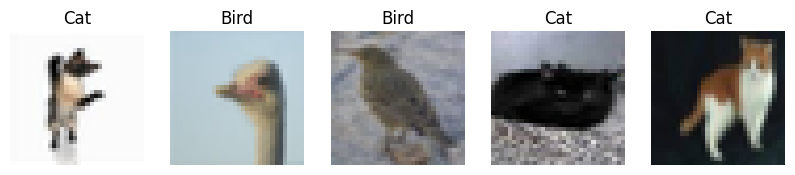

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the unique class labels for each dataset
class_1 = 0  # Airplane, assign label 0
class_2 = 1  # Automobile, assign label 1
class_3 = 2  # Bird, assign label 2
class_4 = 3  # Cat, assign label 3

# Load and filter the CIFAR-10 dataset
def load_and_filter_cifar10(classes, labels, num_train_samples=400, num_test_samples=100):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    # Filter the training and testing data for the selected classes
    train_filter = np.where(np.isin(y_train, classes))[0]
    test_filter = np.where(np.isin(y_test, classes))[0]

    # Shuffle indices for randomness
    np.random.shuffle(train_filter)
    np.random.shuffle(test_filter)

    # Select the first `num_train_samples` and `num_test_samples` from the filtered indices
    train_images = x_train[train_filter][:num_train_samples]
    train_labels = y_train[train_filter][:num_train_samples]
    test_images = x_test[test_filter][:num_test_samples]
    test_labels = y_test[test_filter][:num_test_samples]

    # Map classes to the specified unique labels
    for i, cls in enumerate(classes):
        train_labels = np.where(train_labels == cls, labels[i], train_labels)
        test_labels = np.where(test_labels == cls, labels[i], test_labels)

    return train_images, train_labels, test_images, test_labels

# Load Dataset 1 (Airplane and Automobile) with more samples
train_images_1, train_labels_1, test_images_1, test_labels_1 = load_and_filter_cifar10(
    [class_1, class_2], [0, 1], num_train_samples=400, num_test_samples=100
)

# Load Dataset 2 (Deer and Dog) with more samples
train_images_2, train_labels_2, test_images_2, test_labels_2 = load_and_filter_cifar10(
    [class_3, class_4], [2, 3], num_train_samples=400, num_test_samples=100
)

# Split training data into training and validation sets
def split_data(train_images, train_labels, val_size=80):
    return train_images[:-val_size], train_labels[:-val_size], train_images[-val_size:], train_labels[-val_size:]

# Split Dataset 1 (Bird and Cat)
train_images_1, train_labels_1, val_images_1, val_labels_1 = split_data(train_images_1, train_labels_1)
# Split Dataset 2 (Deer and Dog)
train_images_2, train_labels_2, val_images_2, val_labels_2 = split_data(train_images_2, train_labels_2)

# Display dataset shapes
def display_dataset_shapes():
    print(f"Dataset 1 (Bird and Cat):")
    print(f"  Train images shape: {train_images_1.shape}, Train labels shape: {train_labels_1.shape}")
    print(f"  Validation images shape: {val_images_1.shape}, Validation labels shape: {val_labels_1.shape}")
    print(f"  Test images shape: {test_images_1.shape}, Test labels shape: {test_labels_1.shape}")

    print(f"Dataset 2 (Deer and Dog):")
    print(f"  Train images shape: {train_images_2.shape}, Train labels shape: {train_labels_2.shape}")
    print(f"  Validation images shape: {val_images_2.shape}, Validation labels shape: {val_labels_2.shape}")
    print(f"  Test images shape: {test_images_2.shape}, Test labels shape: {test_labels_2.shape}")

def display_sample_images(images, labels, class_names, num_samples=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        index = np.random.randint(0, len(images))
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[index])
        plt.title(class_names[labels[index][0]])
        plt.axis('off')
    plt.show()

# Display dataset shapes
display_dataset_shapes()

# Define class names for the unique classes
class_names = ["Airplane", "Automobile", "Bird", "Cat"]


print("Sample images from Dataset 1 (Airplane and Automobile):")
display_sample_images(train_images_1, train_labels_1, class_names)


print("Sample images from Dataset 2 (Bird and Cat):")
display_sample_images(train_images_2, train_labels_2, class_names)

Epoch 1/25
Train Loss: 0.6893, Train Acc: 0.6719, Val Loss: 0.6855, Val Acc: 0.7125
Epoch 2/25
Train Loss: 0.6860, Train Acc: 0.6750, Val Loss: 0.6807, Val Acc: 0.7375
Epoch 3/25
Train Loss: 0.6806, Train Acc: 0.6813, Val Loss: 0.6762, Val Acc: 0.7375
Epoch 4/25
Train Loss: 0.6791, Train Acc: 0.6687, Val Loss: 0.6721, Val Acc: 0.7375
Epoch 5/25
Train Loss: 0.6727, Train Acc: 0.6937, Val Loss: 0.6665, Val Acc: 0.7750
Epoch 6/25
Train Loss: 0.6696, Train Acc: 0.7031, Val Loss: 0.6629, Val Acc: 0.7625
Epoch 7/25
Train Loss: 0.6642, Train Acc: 0.7250, Val Loss: 0.6564, Val Acc: 0.7500
Epoch 8/25
Train Loss: 0.6662, Train Acc: 0.6781, Val Loss: 0.6541, Val Acc: 0.7625
Epoch 9/25
Train Loss: 0.6621, Train Acc: 0.6844, Val Loss: 0.6500, Val Acc: 0.7750
Epoch 10/25
Train Loss: 0.6602, Train Acc: 0.6813, Val Loss: 0.6472, Val Acc: 0.7625
Epoch 11/25
Train Loss: 0.6519, Train Acc: 0.7125, Val Loss: 0.6453, Val Acc: 0.7750
Epoch 12/25
Train Loss: 0.6525, Train Acc: 0.7188, Val Loss: 0.6406, Val A

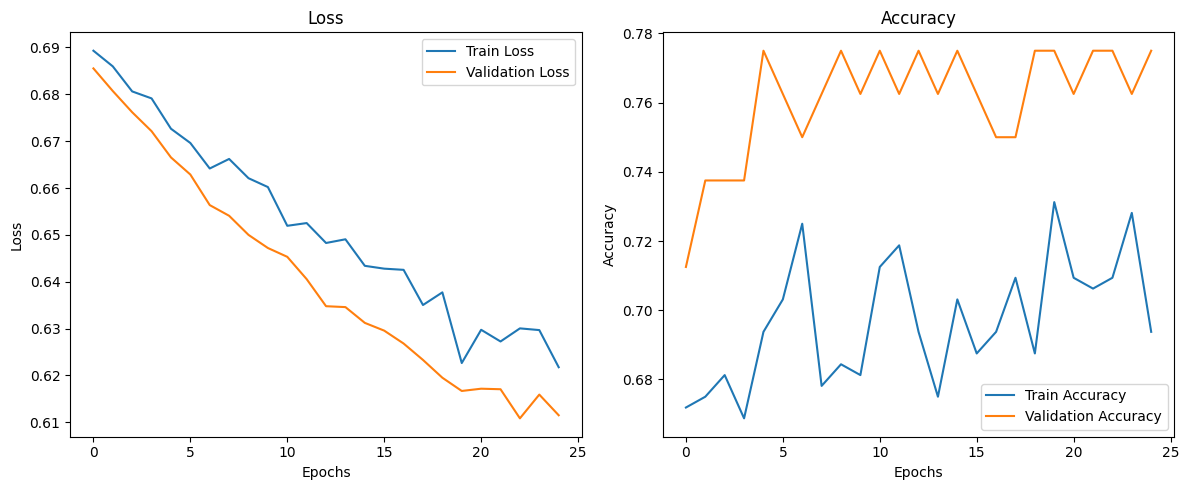

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def forward(image, label):
    image = (image / 255) - 0.5  # Normalize image to [-0.5, 0.5]
    if label == 2:
        label = 0
    elif label == 3:
        label = 1
    # Forward pass through the network
    out = conv1.forward(image)   # Convolutional Layer 1
    out = pool1.forward(out)     # Pooling Layer 1
    out = conv2.forward(out)     # Convolutional Layer 2
    out = pool2.forward(out)     # Pooling Layer 2
    out = dropout1.forward(out)  # Dropout Layer
    out = softmax1.forward(out.flatten())  # Softmax Layer (Flattened)

    acc = 1 if np.argmax(out) == label else 0  # Accuracy based on predicted class
    return out, acc

# Backpropagation for training
def train(im, label, lr=1e-4):
    out, acc = forward(im, label)
    if label == 2:
        label = 0
    elif label == 3:
        label = 1
    loss = -np.log(out[label])  # Cross-entropy loss for binary classification
    gradient = np.zeros(2)  # Assuming binary classification (Bird vs. Cat)
    gradient[label] = -1 / out[label]

    # Backpropagation through layers
    gradient = softmax1.backprop(gradient, lr)  # Fine-tune softmax layer
    gradient = pool2.backprop(gradient.reshape((6, 6, 16)))  # Correct reshape after pooling
    gradient = conv2.backprop(gradient, lr)  # Backprop through conv2
    gradient = pool1.backprop(gradient.reshape((15, 15, 8)))
    gradient = conv1.backprop(gradient, lr)

    return loss, acc
# Define the validate function
def validate(images, labels):
    total_loss = 0.0
    total_acc = 0

    for i in range(len(images)):
        image = images[i]
        label = labels[i][0]  # Assuming labels are one-hot encoded

        if label == 2:
            label = 0
        elif label == 3:
            label = 1
        out, acc = forward(image, label)
        loss = -np.log(out[label])  # Cross-entropy loss

        total_loss += loss
        total_acc += acc

    avg_loss = total_loss / len(images)
    avg_acc = total_acc / len(images)

    return avg_loss, avg_acc

    return loss, acc
# Initialize new layers (convolution, pooling, etc.)
conv1 = Conv3x3(num_filters=8, input_channels=3)  # RGB image has 3 channels
conv2 = Conv3x3(num_filters=16, input_channels=8)  # conv1 output has 8 channels
pool1 = MaxPool2()
pool2 = MaxPool2()
dropout1 = Dropout(drop_prob=0.2)
softmax1 = Softmax(input_len=6 * 6 * 16, nodes=2)

# Data Augmentation Setup (if needed)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)


# Training loop
epochs = 25
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_loss = float('inf')

# Loop over the epochs
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    total_loss = 0.0
    total_acc = 0

    # Training with data augmentation
    for i in range(len(train_images_2)):
        augmented_image = datagen.random_transform(train_images_1[i])  # Apply data augmentation
        loss, acc = train(augmented_image, train_labels_1[i][0])  # Train on augmented image
        total_loss += loss
        total_acc += acc

    avg_train_loss = total_loss / len(train_images_1)
    avg_train_acc = total_acc / len(train_images_1)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation step (assuming validate function is defined elsewhere)
    val_loss, val_acc = validate(val_images_1, val_labels_1)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


# Evaluate on the test set
test_loss, test_acc = validate(test_images_1, test_labels_1)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Save the model weights after all epochs
np.save('conv1_weights.npy', conv1.filters)
np.save('conv2_weights.npy', conv2.filters)
np.save('softmax_weights.npy', softmax1.weights)
print("Model parameters saved after all epochs.")


# Plot the results (Loss and Accuracy)
plt.figure(figsize=(12, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/25
Train Loss: 0.6926, Train Acc: 0.5344, Val Loss: 0.6918, Val Acc: 0.5750
Epoch 2/25
Train Loss: 0.6926, Train Acc: 0.5437, Val Loss: 0.6910, Val Acc: 0.5750
Epoch 3/25
Train Loss: 0.6919, Train Acc: 0.5656, Val Loss: 0.6898, Val Acc: 0.5750
Epoch 4/25
Train Loss: 0.6913, Train Acc: 0.5375, Val Loss: 0.6893, Val Acc: 0.5625
Epoch 5/25
Train Loss: 0.6907, Train Acc: 0.5594, Val Loss: 0.6886, Val Acc: 0.5625
Epoch 6/25
Train Loss: 0.6906, Train Acc: 0.5500, Val Loss: 0.6871, Val Acc: 0.5500
Epoch 7/25
Train Loss: 0.6896, Train Acc: 0.5656, Val Loss: 0.6866, Val Acc: 0.5750
Epoch 8/25
Train Loss: 0.6888, Train Acc: 0.5500, Val Loss: 0.6860, Val Acc: 0.5750
Epoch 9/25
Train Loss: 0.6871, Train Acc: 0.5969, Val Loss: 0.6853, Val Acc: 0.5750
Epoch 10/25
Train Loss: 0.6874, Train Acc: 0.6031, Val Loss: 0.6844, Val Acc: 0.5875
Epoch 11/25
Train Loss: 0.6880, Train Acc: 0.5625, Val Loss: 0.6833, Val Acc: 0.5875
Epoch 12/25
Train Loss: 0.6867, Train Acc: 0.5781, Val Loss: 0.6829, Val A

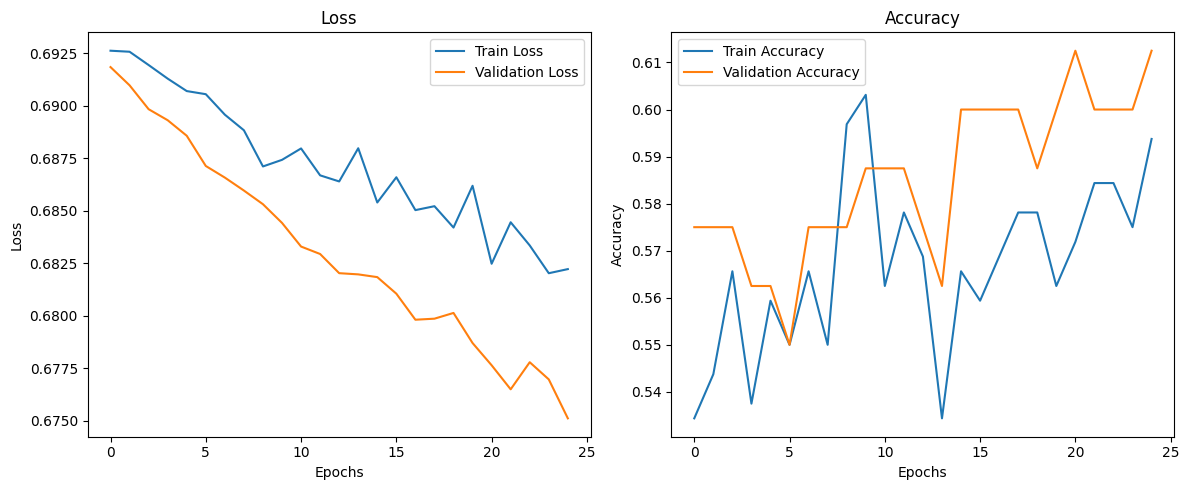

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define or import your custom CNN classes (Conv3x3, MaxPool2, Dropout, Softmax)

# Assuming Conv3x3, MaxPool2, Dropout, Softmax, etc., are already defined as per the previous examples
def map_labels(labels):
    return [[0] if label == 2 else [1] for label in labels]
def forward(image, label):
    if label == 2:
        label = 0
    elif label == 3:
        label = 1
    image = (image / 255) - 0.5  # Normalize image to [-0.5, 0.5]

    # Forward pass through the network
    out = conv21.forward(image)   # Convolutional Layer 1
    out = pool21.forward(out)     # Pooling Layer 1
    out = conv22.forward(out)     # Convolutional Layer 2
    out = pool22.forward(out)     # Pooling Layer 2
    out = dropout21.forward(out)  # Dropout Layer
    out = softmax21.forward(out.flatten())  # Softmax Layer (Flattened)

    acc = 1 if np.argmax(out) == label else 0  # Accuracy based on predicted class
    return out, acc

# Backpropagation for training
def train(im, label, lr=1e-4):
    out, acc = forward(im, label)
    if label == 2:
        label = 0
    elif label == 3:
        label = 1
    loss = -np.log(out[label])  # Cross-entropy loss for binary classification
    gradient = np.zeros(2)  # Assuming binary classification (Bird vs. Cat)
    gradient[label] = -1 / out[label]

    # Backpropagation through layers
    gradient = softmax21.backprop(gradient, lr)  # Fine-tune softmax layer
    gradient = pool22.backprop(gradient.reshape((6, 6, 16)))  # Correct reshape after pooling
    gradient = conv22.backprop(gradient, lr)  # Backprop through conv2
    gradient = pool21.backprop(gradient.reshape((15, 15, 8)))  # Correct reshape after pooling
    gradient = conv21.backprop(gradient, lr)  # Backprop through conv1 (but conv1 is frozen)

    return loss, acc
# Define the validate function
def validate(images, labels):
    total_loss = 0.0
    total_acc = 0

    for i in range(len(images)):
        image = images[i]
        label = labels[i][0]  # Assuming labels are one-hot encoded

        if label == 2:
            label = 0
        elif label == 3:
            label = 1
        out, acc = forward(image, label)
        loss = -np.log(out[label])  # Cross-entropy loss

        total_loss += loss
        total_acc += acc

    avg_loss = total_loss / len(images)
    avg_acc = total_acc / len(images)

    return avg_loss, avg_acc

# Initialize new layers (convolution, pooling, etc.)
conv21 = Conv3x3(num_filters=8, input_channels=3)  # RGB image has 3 channels
conv22 = Conv3x3(num_filters=16, input_channels=8)  # conv1 output has 8 channels, so conv2 should take 8 channels as input
pool21 = MaxPool2()
pool22 = MaxPool2()
dropout21 = Dropout(drop_prob=0.2)
softmax21 = Softmax(input_len=6 * 6 * 16, nodes=2)
# Data Augmentation Setup (if needed)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)



# Training loop
epochs = 25
train_losses1 = []
val_losses1 = []
train_accuracies1 = []
val_accuracies1 = []
best_val_loss1 = float('inf')

# Loop over the epochs
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    total_loss = 0.0
    total_acc = 0

    # Training with data augmentation
    for i in range(len(train_images_2)):
        augmented_image = datagen.random_transform(train_images_2[i])  # Apply data augmentation
        loss, acc = train(augmented_image, train_labels_2[i][0])  # Train on augmented image
        total_loss += loss
        total_acc += acc

    avg_train_loss = total_loss / len(train_images_2)
    avg_train_acc = total_acc / len(train_images_2)
    train_losses1.append(avg_train_loss)
    train_accuracies1.append(avg_train_acc)

    # Validation step (assuming validate function is defined elsewhere)
    val_loss, val_acc = validate(val_images_2, val_labels_2)
    val_losses1.append(val_loss)
    val_accuracies1.append(val_acc)

    print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


# Evaluate on the test set
test_loss, test_acc = validate(test_images_2, test_labels_2)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Plot the results (Loss and Accuracy)
plt.figure(figsize=(12, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses1, label='Train Loss')
plt.plot(val_losses1, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies1, label='Train Accuracy')
plt.plot(val_accuracies1, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/25
Train Loss: 0.7178, Train Acc: 0.5188, Val Loss: 0.7036, Val Acc: 0.5375
Epoch 2/25
Train Loss: 0.7168, Train Acc: 0.5188, Val Loss: 0.6963, Val Acc: 0.5500
Epoch 3/25
Train Loss: 0.7045, Train Acc: 0.5188, Val Loss: 0.6925, Val Acc: 0.5625
Epoch 4/25
Train Loss: 0.7074, Train Acc: 0.4875, Val Loss: 0.6902, Val Acc: 0.5750
Epoch 5/25
Train Loss: 0.7019, Train Acc: 0.5312, Val Loss: 0.6870, Val Acc: 0.5750
Epoch 6/25
Train Loss: 0.6957, Train Acc: 0.5563, Val Loss: 0.6879, Val Acc: 0.5625
Epoch 7/25
Train Loss: 0.6935, Train Acc: 0.5656, Val Loss: 0.6855, Val Acc: 0.5625
Epoch 8/25
Train Loss: 0.6940, Train Acc: 0.5344, Val Loss: 0.6810, Val Acc: 0.5625
Epoch 9/25
Train Loss: 0.6913, Train Acc: 0.5469, Val Loss: 0.6814, Val Acc: 0.5875
Epoch 10/25
Train Loss: 0.6891, Train Acc: 0.5375, Val Loss: 0.6786, Val Acc: 0.6000
Epoch 11/25
Train Loss: 0.6855, Train Acc: 0.5469, Val Loss: 0.6786, Val Acc: 0.6125
Epoch 12/25
Train Loss: 0.6879, Train Acc: 0.5500, Val Loss: 0.6769, Val A

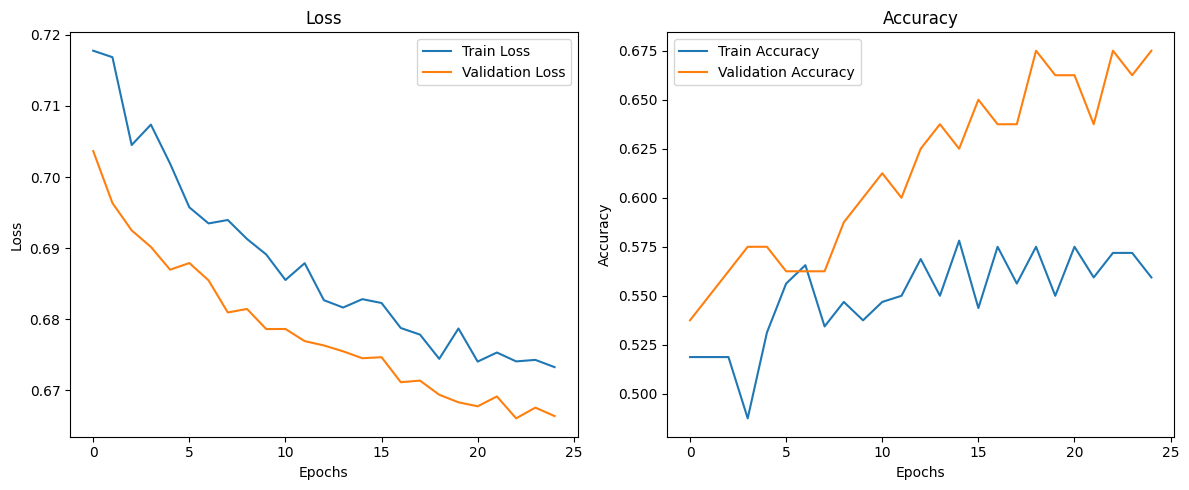

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Forward pass through the network
def forward(image, label):
    if label == 2:
        label = 0
    elif label == 3:
        label = 1
    image = (image / 255) - 0.5  # Normalize image to [-0.5, 0.5]

    # Forward pass through the network
    out = conv31.forward(image)   # Convolutional Layer 1
    out = pool31.forward(out)     # Pooling Layer 1
    out = conv32.forward(out)     # Convolutional Layer 2
    out = pool32.forward(out)     # Pooling Layer 2
    out = dropout31.forward(out)  # Dropout Layer
    out = softmax31.forward(out.flatten())  # Softmax Layer (Flattened)

    acc = 1 if np.argmax(out) == label else 0  # Accuracy based on predicted class
    return out, acc

# Backpropagation for training
def train(im, label, lr=1e-4):
    out, acc = forward(im, label)
    if label == 2:
        label = 0
    elif label == 3:
        label = 1
    loss = -np.log(out[label])  # Cross-entropy loss for binary classification
    gradient = np.zeros(2)  # Assuming binary classification (Bird vs. Cat)
    gradient[label] = -1 / out[label]

    # Backpropagation through layers
    gradient = softmax31.backprop(gradient, lr)  # Fine-tune softmax layer
    gradient = pool32.backprop(gradient.reshape((6, 6, 16)))  # Correct reshape after pooling
    gradient = conv32.backprop(gradient, lr)  # Backprop through conv2
    gradient = pool31.backprop(gradient.reshape((15, 15, 8)))  # Correct reshape after pooling
    gradient = conv31.backprop(gradient, lr)  # Backprop through conv1 (but conv1 is frozen)

    return loss, acc

# Define the validate function
def validate(images, labels):
    total_loss = 0.0
    total_acc = 0

    for i in range(len(images)):
        image = images[i]
        label = labels[i][0]  # Assuming labels are one-hot encoded

        if label == 2:
            label = 0
        elif label == 3:
            label = 1
        out, acc = forward(image, label)
        loss = -np.log(out[label])  # Cross-entropy loss
        total_loss += loss
        total_acc += acc

    avg_loss = total_loss / len(images)
    avg_acc = total_acc / len(images)

    return avg_loss, avg_acc

# Initialize layers and load pre-trained weights
conv31 = Conv3x3(num_filters=8, input_channels=3)  # Convolutional Layer 1
conv32 = Conv3x3(num_filters=16, input_channels=8)  # Convolutional Layer 2
pool31 = MaxPool2()  # Max pooling layer 1
pool32 = MaxPool2()  # Max pooling layer 2
dropout31 = Dropout(drop_prob=0.2)  # Dropout layer with 20% drop probability
softmax31 = Softmax(input_len=6 * 6 * 16, nodes=2)  # Softmax layer for binary classification

# Load pre-trained filters (convolutional and softmax)
conv1_filters = np.load('conv1_weights.npy')  # Loaded from a pre-trained model
conv2_filters = np.load('conv2_weights.npy')
softmax_weights = np.load('softmax_weights.npy')  # Load best softmax weights

# Apply pre-trained weights to layers
conv31.filters = conv1_filters
conv32.filters = conv2_filters
softmax31.weights = softmax_weights  # Load the best softmax weights

# Initialize data augmentation for Dataset 2 (Bird and Cat)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Training loop on Dataset 2 (Bird and Cat)
epochs = 25
train_losses2 = []
val_losses2 = []
train_accuracies2 = []
val_accuracies2= []
best_val_loss2 = float('inf')

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    total_loss = 0.0
    total_acc = 0

    # Training step with data augmentation on Dataset 2
    for i in range(len(train_images_2)):
        augmented_image = datagen.random_transform(train_images_2[i])  # Data augmentation
        loss, acc = train(augmented_image, train_labels_2[i][0])  # Train on augmented data for Dataset 2
        total_loss += loss
        total_acc += acc

    avg_train_loss = total_loss / len(train_images_2)
    avg_train_acc = total_acc / len(train_images_2)
    train_losses2.append(avg_train_loss)
    train_accuracies2.append(avg_train_acc)

    # Validation step on Dataset 2
    val_loss, val_acc = validate(val_images_2, val_labels_2)
    val_losses2.append(val_loss)
    val_accuracies2.append(val_acc)

    # Print results for this epoch
    print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Save the best model based on validation loss
    if val_loss < best_val_loss2:
        best_val_loss2 = val_loss
        np.save('best_conv1_weights.npy', conv31.filters)  # Saving the new best conv1 filters
        np.save('best_conv2_weights.npy', conv32.filters)  # Saving the new best conv2 filters
        np.save('best_softmax_weights.npy', softmax31.weights)  # Saving the new best softmax weights

# Evaluate on the test set of Dataset 2 (Bird and Cat)
test_loss, test_acc = validate(test_images_2, test_labels_2)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Plot the results (Loss and Accuracy)
plt.figure(figsize=(12, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses2, label='Train Loss')
plt.plot(val_losses2, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies2, label='Train Accuracy')
plt.plot(val_accuracies2, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


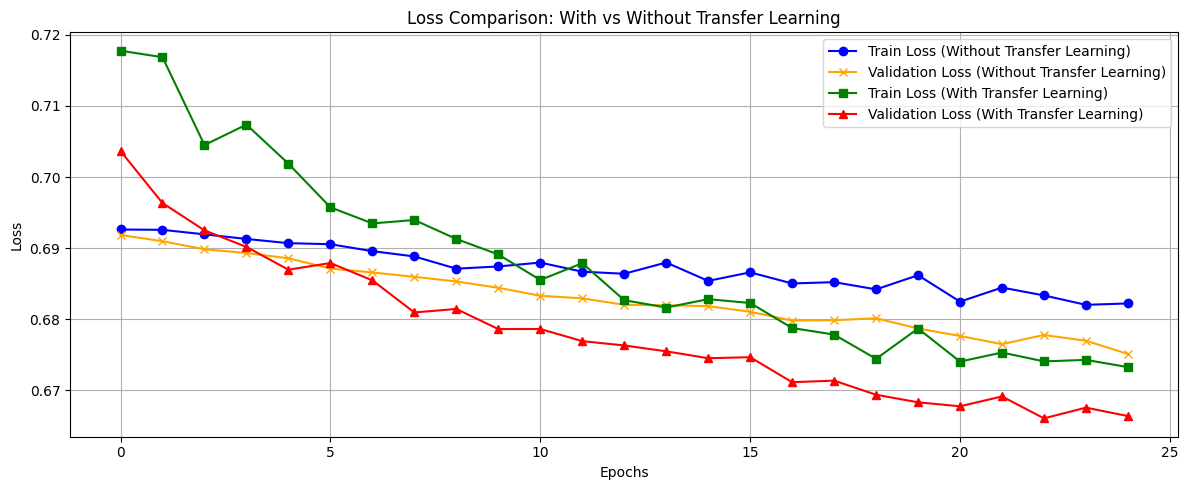

In [ ]:
import matplotlib.pyplot as plt

# Create a combined plot for loss comparison
plt.figure(figsize=(12, 5))

# Plot training and validation loss without transfer learning
plt.plot(train_losses1, label='Train Loss (Without Transfer Learning)', color='blue', marker='o')
plt.plot(val_losses1, label='Validation Loss (Without Transfer Learning)', color='orange', marker='x')

# Plot training and validation loss with transfer learning
plt.plot(train_losses2, label='Train Loss (With Transfer Learning)', color='green', marker='s')
plt.plot(val_losses2, label='Validation Loss (With Transfer Learning)', color='red', marker='^')

# Add labels and title
plt.title('Loss Comparison: With vs Without Transfer Learning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


Epoch 1/25
Train Loss: 0.6930, Train Acc: 0.5406, Val Loss: 0.6848, Val Acc: 0.5625
Epoch 2/25
Train Loss: 0.6898, Train Acc: 0.5531, Val Loss: 0.6817, Val Acc: 0.6125
Epoch 3/25
Train Loss: 0.6841, Train Acc: 0.5437, Val Loss: 0.6765, Val Acc: 0.6250
Epoch 4/25
Train Loss: 0.6807, Train Acc: 0.5500, Val Loss: 0.6713, Val Acc: 0.6250
Epoch 5/25
Train Loss: 0.6749, Train Acc: 0.5719, Val Loss: 0.6680, Val Acc: 0.6000
Epoch 6/25
Train Loss: 0.6745, Train Acc: 0.5719, Val Loss: 0.6639, Val Acc: 0.6125
Epoch 7/25
Train Loss: 0.6681, Train Acc: 0.5813, Val Loss: 0.6670, Val Acc: 0.6125
Epoch 8/25
Train Loss: 0.6663, Train Acc: 0.6062, Val Loss: 0.6617, Val Acc: 0.6625
Epoch 9/25
Train Loss: 0.6635, Train Acc: 0.6125, Val Loss: 0.6609, Val Acc: 0.6625
Epoch 10/25
Train Loss: 0.6634, Train Acc: 0.6031, Val Loss: 0.6559, Val Acc: 0.6625
Epoch 11/25
Train Loss: 0.6612, Train Acc: 0.6031, Val Loss: 0.6564, Val Acc: 0.7000
Epoch 12/25
Train Loss: 0.6560, Train Acc: 0.6594, Val Loss: 0.6526, Val A

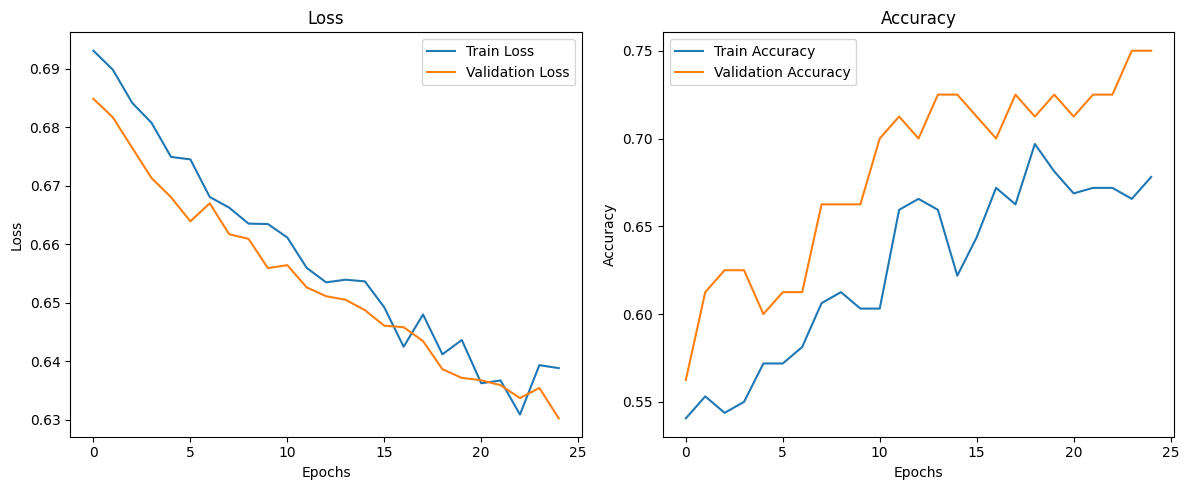

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


class Conv3x3__11:
    """
    A convolutional layer using 3x3 filters with optional pre-trained weights.
    Supports dynamic scalar multipliers for efficient transfer learning.
    """
    def __init__(self, num_filters, input_channels, pretrained_filters=None):
        self.num_filters = num_filters

        if pretrained_filters is not None:
            # Use pre-trained filters
            self.filters = pretrained_filters
        else:
            # Initialize random filters with shape (num_filters, 3, 3, input_channels)
            self.filters = np.random.randn(num_filters, 3, 3, input_channels) / 9

        # Initialize scalar weights and scalars
        self.filter_weights = np.ones(num_filters)  # Fine-tuning scalar weights
        self.filter_scalars = np.random.rand(num_filters)  # Randomly initialized scalars

    def iterate_regions(self, image):
        """
        Generator to iterate over 3x3 regions of the input image.
        Yields:
            im_region: The 3x3 region of the image.
            i, j: The top-left coordinates of the region.
        """
        h, w, _ = image.shape
        for i in range(h - 2):
            for j in range(w - 2):
                im_region = image[i:(i + 3), j:(j + 3), :]
                yield im_region, i, j

    def forward(self, input):
        """
        Perform the forward pass using convolution.
        Args:
            input: Input image (height, width, channels).
        Returns:
            output: Convolved feature map.
        """
        self.last_input = input
        h, w, _ = input.shape
        output_height, output_width = h - 2, w - 2
        output = np.zeros((output_height, output_width, self.num_filters))

        # Compute scaled filter weights dynamically
        scaled_filters = self.filters * (self.filter_weights[:, None, None, None] * self.filter_scalars[:, None, None, None])

        # Perform convolution over each 3x3 region
        for im_region, i, j in self.iterate_regions(input):
            # Convolve region with each filter
            conv_results = np.sum(im_region * scaled_filters, axis=(1, 2, 3))
            output[i, j, :] = conv_results

        return output

    def backprop(self, d_L_d_out, learn_rate):
        """
        Perform the backward pass and update filters, weights, and scalars.
        Args:
            d_L_d_out: Gradient of loss with respect to output.
            learn_rate: Learning rate for parameter updates.
        Returns:
            d_L_d_input: Gradient of loss with respect to input.
        """
        d_L_d_filters = np.zeros(self.filters.shape)
        d_L_d_filter_weights = np.zeros(self.filter_weights.shape)
        d_L_d_filter_scalars = np.zeros(self.filter_scalars.shape)
        d_L_d_input = np.zeros(self.last_input.shape)

        # Backpropagate through each region
        for im_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                scalar_weight = self.filter_weights[f] * self.filter_scalars[f]

                # Gradient for the scalar weights
                d_L_d_filter_weights[f] += np.sum(d_L_d_out[i, j, f] * im_region * self.filters[f] * self.filter_scalars[f])

                # Gradient for the filter scalars
                d_L_d_filter_scalars[f] += np.sum(d_L_d_out[i, j, f] * im_region * self.filters[f] * self.filter_weights[f])

                # Gradient for the filters (with the scalar applied)
                d_L_d_filters[f] += d_L_d_out[i, j, f] * scalar_weight * im_region

                # Gradient for the input
                d_L_d_input[i:i + 3, j:j + 3, :] += d_L_d_out[i, j, f] * scalar_weight * self.filters[f]

        # Update filters, weights, and scalars
        self.filters -= learn_rate * d_L_d_filters
        self.filter_weights -= learn_rate * d_L_d_filter_weights
        self.filter_scalars -= learn_rate * d_L_d_filter_scalars

        # Ensure scalars are within the range [0, 1]
        self.filter_scalars = np.clip(self.filter_scalars, 0, 1)

        return d_L_d_input
class Conv3x3Efficient:
    """
    An efficient convolutional layer using 3x3 filters for transfer learning.
    Supports pre-trained weights, dynamic modulation, and fine-tuning.
    """
    def __init__(self, num_filters, input_channels, pretrained_filters=None):
        self.num_filters = num_filters

        if pretrained_filters is not None:
            # Use pre-trained filters (modifiable component)
            self.pretrained_filters = pretrained_filters
        else:
            # Initialize random filters for pre-training
            self.pretrained_filters = np.random.randn(num_filters, 3, 3, input_channels) / 9

        # Initialize dynamic fine-tuned filters
        self.fine_tune_filters = np.random.randn(num_filters, 3, 3, input_channels) / 9

        # Initialize scalar modulation factors
        self.scalar_modulation = np.ones(num_filters)

    def iterate_regions(self, image):
        """
        Generator to iterate over 3x3 regions of the input image.
        Yields:
            im_region: The 3x3 region of the image.
            i, j: The top-left coordinates of the region.
        """
        h, w, _ = image.shape
        for i in range(h - 2):
            for j in range(w - 2):
                im_region = image[i:(i + 3), j:(j + 3), :]
                yield im_region, i, j

    def forward(self, input):
        """
        Perform the forward pass using convolution.
        Args:
            input: Input image (height, width, channels).
        Returns:
            output: Convolved feature map.
        """
        self.last_input = input
        h, w, _ = input.shape
        output_height, output_width = h - 2, w - 2
        output = np.zeros((output_height, output_width, self.num_filters))

        # Combined filters (pre-trained + fine-tuned) with scalar modulation
        combined_filters = (
            self.pretrained_filters * self.scalar_modulation[:, None, None, None] +
            self.fine_tune_filters
        )

        # Perform convolution over each 3x3 region
        for im_region, i, j in self.iterate_regions(input):
            # Convolve region with each filter
            conv_results = np.sum(im_region * combined_filters, axis=(1, 2, 3))
            output[i, j, :] = conv_results

        return output

    def backprop(self, d_L_d_out, learn_rate):
        """
        Perform the backward pass and update filters and scalar modulation.
        Args:
            d_L_d_out: Gradient of loss with respect to output.
            learn_rate: Learning rate for parameter updates.
        Returns:
            d_L_d_input: Gradient of loss with respect to input.
        """
        d_L_d_pretrained = np.zeros(self.pretrained_filters.shape)
        d_L_d_fine_tune = np.zeros(self.fine_tune_filters.shape)
        d_L_d_scalars = np.zeros(self.scalar_modulation.shape)
        d_L_d_input = np.zeros(self.last_input.shape)

        # Backpropagate through each region
        for im_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                scalar_modulation = self.scalar_modulation[f]

                # Gradients for scalars
                d_L_d_scalars[f] += np.sum(d_L_d_out[i, j, f] * im_region * self.pretrained_filters[f])

                # Gradients for the pre-trained filters
                d_L_d_pretrained[f] += d_L_d_out[i, j, f] * scalar_modulation * im_region

                # Gradients for the fine-tuned filters
                d_L_d_fine_tune[f] += d_L_d_out[i, j, f] * im_region

                # Gradient for the input
                d_L_d_input[i:i + 3, j:j + 3, :] += (
                    d_L_d_out[i, j, f] * scalar_modulation * self.pretrained_filters[f] +
                    d_L_d_out[i, j, f] * self.fine_tune_filters[f]
                )

        # Update filters and scalars
        self.pretrained_filters -= learn_rate * d_L_d_pretrained
        self.fine_tune_filters -= learn_rate * d_L_d_fine_tune
        self.scalar_modulation -= learn_rate * d_L_d_scalars

        # Ensure scalars remain within [0, 1]
        self.scalar_modulation = np.clip(self.scalar_modulation, 0, 1)

        return d_L_d_input





# Forward pass through the network
def forward(image, label):
    if label == 2:
        label = 0
    elif label == 3:
        label = 1
    image = (image / 255) - 0.5  # Normalize image to [-0.5, 0.5]

    # Forward pass through the network
    out = conv31.forward(image)   # Convolutional Layer 1
    out = pool31.forward(out)     # Pooling Layer 1
    out = conv32.forward(out)     # Convolutional Layer 2
    out = pool32.forward(out)     # Pooling Layer 2
    out = dropout31.forward(out)  # Dropout Layer
    out = softmax31.forward(out.flatten())  # Softmax Layer (Flattened)

    acc = 1 if np.argmax(out) == label else 0  # Accuracy based on predicted class
    return out, acc

# Backpropagation for training
def train(im, label, lr=1e-4):
    out, acc = forward(im, label)
    if label == 2:
        label = 0
    elif label == 3:
        label = 1
    loss = -np.log(out[label])  # Cross-entropy loss for binary classification
    gradient = np.zeros(2)  # Assuming binary classification (Bird vs. Cat)
    gradient[label] = -1 / out[label]

    # Backpropagation through layers
    gradient = softmax31.backprop(gradient, lr)  # Fine-tune softmax layer
    gradient = pool32.backprop(gradient.reshape((6, 6, 16)))  # Correct reshape after pooling
    gradient = conv32.backprop(gradient, lr)  # Backprop through conv2
    gradient = pool31.backprop(gradient.reshape((15, 15, 8)))  # Correct reshape after pooling
    gradient = conv31.backprop(gradient, lr)  # Backprop through conv1 (but conv1 is frozen)

    return loss, acc

# Define the validate function
def validate(images, labels):
    total_loss = 0.0
    total_acc = 0

    for i in range(len(images)):
        image = images[i]
        label = labels[i][0]  # Assuming labels are one-hot encoded

        if label == 2:
            label = 0
        elif label == 3:
            label = 1
        out, acc = forward(image, label)
        loss = -np.log(out[label])  # Cross-entropy loss
        total_loss += loss
        total_acc += acc

    avg_loss = total_loss / len(images)
    avg_acc = total_acc / len(images)

    return avg_loss, avg_acc

# Initialize layers and load pre-trained weights
conv1_filters = np.load('conv1_weights.npy')  # Loaded from a pre-trained model
conv2_filters = np.load('conv2_weights.npy')
softmax_weights = np.load('softmax_weights.npy')


conv31 = Conv3x3Efficient(num_filters=8, input_channels=3, pretrained_filters=conv1_filters)
conv32 = Conv3x3Efficient(num_filters=16, input_channels=8, pretrained_filters=conv2_filters)  # Convolutional Layer 2
pool31 = MaxPool2()  # Max pooling layer 1
pool32 = MaxPool2()  # Max pooling layer 2
dropout31 = Dropout(drop_prob=0.2)  # Dropout layer with 20% drop probability
softmax31 = Softmax(input_len=6 * 6 * 16, nodes=2)  # Softmax layer for binary classification


softmax31.weights = softmax_weights  # Load the best softmax weights

# Initialize data augmentation for Dataset 2 (Bird and Cat)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Training loop on Dataset 2 (Bird and Cat)
epochs = 25
train_losses2 = []
val_losses2 = []
train_accuracies2 = []
val_accuracies2= []
best_val_loss2 = float('inf')

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    total_loss = 0.0
    total_acc = 0

    # Training step with data augmentation on Dataset 2
    for i in range(len(train_images_2)):
        augmented_image = datagen.random_transform(train_images_2[i])  # Data augmentation
        loss, acc = train(augmented_image, train_labels_2[i][0])  # Train on augmented data for Dataset 2
        total_loss += loss
        total_acc += acc

    avg_train_loss = total_loss / len(train_images_2)
    avg_train_acc = total_acc / len(train_images_2)
    train_losses2.append(avg_train_loss)
    train_accuracies2.append(avg_train_acc)

    # Validation step on Dataset 2
    val_loss, val_acc = validate(val_images_2, val_labels_2)
    val_losses2.append(val_loss)
    val_accuracies2.append(val_acc)

    # Print results for this epoch
    print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')



# Evaluate on the test set of Dataset 2 (Bird and Cat)
test_loss, test_acc = validate(test_images_2, test_labels_2)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Plot the results (Loss and Accuracy)
plt.figure(figsize=(12, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses2, label='Train Loss')
plt.plot(val_losses2, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies2, label='Train Accuracy')
plt.plot(val_accuracies2, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()




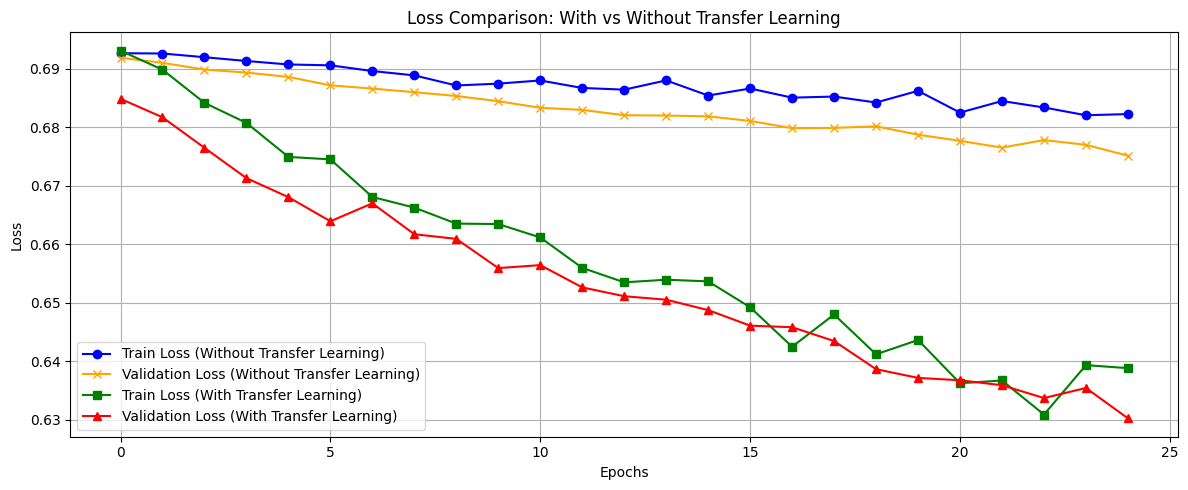

In [ ]:
import matplotlib.pyplot as plt

# Create a combined plot for loss comparison
plt.figure(figsize=(12, 5))

# Plot training and validation loss without transfer learning
plt.plot(train_losses1, label='Train Loss (Without Transfer Learning)', color='blue', marker='o')
plt.plot(val_losses1, label='Validation Loss (Without Transfer Learning)', color='orange', marker='x')

# Plot training and validation loss with transfer learning
plt.plot(train_losses2, label='Train Loss (With Transfer Learning)', color='green', marker='s')
plt.plot(val_losses2, label='Validation Loss (With Transfer Learning)', color='red', marker='^')

# Add labels and title
plt.title('Loss Comparison: With vs Without Transfer Learning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
